# Beat Analysis

Here I'm analysing the data generated from the rust code, to train on the model.

In [71]:
import os.path
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt

In [7]:
TRACK_DIR = "../mixxx_data"

In [57]:
def load_data(filename):
    file = os.path.join(TRACK_DIR, filename)
    with open(file, 'rb') as f:
        data = dict(pickle.load(f))
    return data

In [58]:
data = load_data("amelie.pickle")
target = np.array(data['target'])[:,None]
hist = np.array(data['hist'])
joined_data = np.hstack((hist, target))
joined_data = np.clip(joined_data, 0, 1)

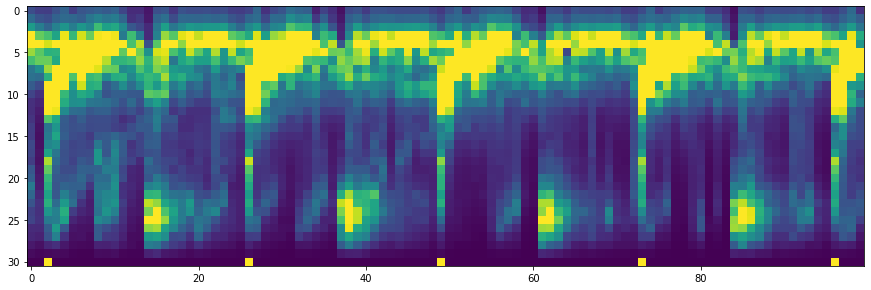

In [59]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x = 6000
ax.imshow(joined_data[x:x+100].T)

## Generate Training Data



In [60]:
def get_pos_neg_indices(min_len_sample: int, target):
    pos_indices = [i for i in range(len(target)) if i > min_len_sample and target[i]]
    neg_indices = [i for i in range(len(target)) if i > min_len_sample and not target[i]]
    return pos_indices, neg_indices

In [76]:
data = load_data("amelie.pickle")
target = data['target']
hist = data['hist']
p, n = get_pos_neg_indices(200, target)
random.shuffle(p)
random.shuffle(n)

In [187]:
tr_p_set_size = round(len(p) * 0.7)
tr_n_set_size = tr_p_set_size * 3
va_p_set_size = len(p) - tr_p_set_size
va_n_set_size = va_p_set_size * 3

In [151]:
def get_samples(indices, sample_len, hist, target_val):
    result = []
    for i in indices:
        r = {
            'input': np.flip(np.array(hist[i - sample_len - 1 : i - 1], dtype=np.single), axis=0).flatten(),
            'target': np.array(target_val, dtype=np.single)
        }
        result.append(r)
    return result

In [188]:
tr_p_samples = get_samples(p[:tr_p_set_size], 200, hist, 1)
tr_n_samples = get_samples(n[:tr_n_set_size], 200, hist, 0)
tr_samples = tr_p_samples + tr_n_samples
# validation
va_p_samples = get_samples(p[tr_p_set_size:tr_p_set_size+va_p_set_size], 200, hist, 1)
va_n_samples = get_samples(n[tr_n_set_size:tr_n_set_size+va_n_set_size], 200, hist, 0)
va_samples = va_p_samples + va_n_samples

## Neural Network

In [154]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [194]:
class SimpleFF(nn.Module):
    def __init__(self,
                 input_features: int):
        super(SimpleFF, self).__init__()
        self.ff = nn.Linear(input_features, 1)
        
    def forward(self, inputs):
        out = inputs
        out = self.ff(out)
        out = torch.sigmoid(out)
        return out

In [195]:
def validate_model(model, data_loader):
    model.eval()
    correct = 0
    tr_loader = DataLoader(all_samples, shuffle=True)
    for sample in tr_loader:
        out = model(sample['input'])
        beat = out.data[0] > 0.5
        correct += beat == (sample['target'] == 1)
    v = float(correct)/len(tr_loader)
    return v

def train(model, tr_set, va_set, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    tr_loader = DataLoader(tr_set, shuffle=True)
    va_loader = DataLoader(va_set, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in tr_loader:
            x = sample['input']
            y = sample['target']
            out = model(x)
            #print(f"out: {out}")
            loss = F.mse_loss(out, y[:,None])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        tr_acc = validate_model(model, tr_loader)
        va_acc = validate_model(model, va_loader)
        print(f"Acc tr: {tr_acc:.02f}; va: {va_acc:.02f}")

In [196]:
model = SimpleFF(6000)
train(model, tr_samples, va_samples, epochs=5)

Acc tr: 0.96; va: 0.96
Acc tr: 0.98; va: 0.98
Acc tr: 0.99; va: 0.99
Acc tr: 0.96; va: 0.96
Acc tr: 0.99; va: 0.99



In [197]:
w = model.ff.weight.detach().numpy().reshape((200, 30))

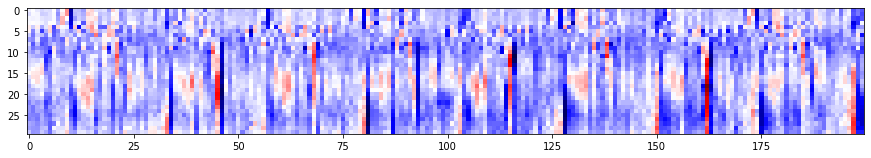

In [198]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(w.T, cmap='seismic')